In [1]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

In [3]:
%%time
# load lite version of Gaia DR3 for quick cone searches
gaia_lite = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", columns=['ra',
                                                                                         'dec', 
                                                                                         "parallax", 
                                                                                         "phot_g_mean_mag"])

CPU times: user 3.38 s, sys: 384 ms, total: 3.77 s
Wall time: 3.76 s


In [4]:
%%time
#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic")

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 55.9 s, sys: 4.93 s, total: 1min
Wall time: 1min


In [9]:
%%time
# crossmatch ZTF + Gaia - for the sake of speed - let's do a simple cone search.
_all_sky_object = gaia.cone_search(ra=113.720378, dec=0.032398, radius=1).crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5").compute()

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

CPU times: user 12 s, sys: 17.1 s, total: 29.1 s
Wall time: 3.77 s


In [10]:
%%time 
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky_object, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 659 ms, sys: 52 ms, total: 711 ms
Wall time: 732 ms


In [11]:
%%time
# merge sources to sample hips object
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 3.27 s, sys: 244 ms, total: 3.51 s
Wall time: 3.51 s


In [14]:
# Initialize an Ensemble
ens = Ensemble(memory_limit=1e11, n_workers=12)
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40009 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40009/status,
Dashboard: http://127.0.0.1:40009/status,Workers: 12
Total threads: 96,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41337,Workers: 12
Dashboard: http://127.0.0.1:40009/status,Total threads: 96
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:32996,Total threads: 8
Dashboard: http://127.0.0.1:40174/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:35454,


In [17]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

In [18]:
%%time
# We can read from parquet
ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

CPU times: user 110 ms, sys: 11 ms, total: 121 ms
Wall time: 114 ms


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [39]:
ens.object.head(12)

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
6124190825120268288,1636148068921376768,Gaia DR3 3062095391795176704,3062095391795176704,647096360,2016.0,113.558199,0.033660,-0.948845,0.030507,0.310495,...,15.942120,15.523130,15.385762,4,0,1359,0.000014,5,0,5439
6124191013062836224,1636148068921376768,Gaia DR3 3062095494874379008,3062095494874379008,370690026,2016.0,113.582820,0.062293,-0.939294,0.057389,0.378925,...,17.238577,16.738188,16.590185,4,0,1359,0.000014,5,0,5439
6124191246257750016,1636148068921376768,Gaia DR3 3062095597953589632,3062095597953589632,235104818,2016.0,113.577875,0.042522,-0.917951,0.038225,0.346192,...,16.337953,15.993256,15.891569,4,0,1359,0.000014,5,0,5439
6124191326687723520,1636148068921376768,Gaia DR3 3062095666673083520,3062095666673083520,179532282,2016.0,113.545066,0.043635,-0.939068,0.038816,0.363434,...,16.606862,16.145748,16.011954,4,0,1359,0.000016,5,0,5439
6124284960145670144,1636148068921376768,Gaia DR3 3062142460339382912,3062142460339382912,1658604876,2016.0,113.442010,0.037339,-0.924221,0.035114,0.425507,...,16.103024,15.808970,15.726223,4,0,1359,0.000018,5,0,5439
6124285425998626816,1636148068921376768,Gaia DR3 3062142705154910464,3062142705154910464,1098368681,2016.0,113.506225,0.053971,-0.913704,0.050655,0.392522,...,16.999563,16.692461,16.616608,4,0,1359,0.000018,5,0,5439
6124285419317100544,1636148068921376768,Gaia DR3 3062142705154912128,3062142705154912128,625760583,2016.0,113.505677,0.029918,-0.917369,0.028368,0.640061,...,15.884443,15.439947,15.318782,4,0,1359,0.000012,5,0,5439
6124285541832720384,1636148068921376768,Gaia DR3 3062142773874379008,3062142773874379008,53990859,2016.0,113.530659,0.037677,-0.912053,0.035003,0.421123,...,16.433137,16.006486,15.870454,4,0,1359,0.000012,5,0,5439
6124285644991627264,1636148068921376768,Gaia DR3 3062142808234109056,3062142808234109056,1429566893,2016.0,113.536483,0.043960,-0.897743,0.040821,0.450942,...,16.824941,16.355443,16.201954,4,0,1359,0.000016,5,0,5439


In [40]:
%%time
lc = ens.source.loc[6124285425998626816].compute()

CPU times: user 598 ms, sys: 273 ms, total: 870 ms
Wall time: 2.95 s


## Local Tools

In [35]:
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate

In [37]:
%%time
# demo tool estimate the nearest neighbour given ra, dec
my_tools.estimate_gaiadr3_density(131.1, 22.3, gaia_lite)

CPU times: user 860 ms, sys: 317 ms, total: 1.18 s
Wall time: 3.86 s


{'closest_bright_star_arcsec': 36.39390440082004,
 'closest_bright_star_mag': 16.448757,
 'closest_star_arcsec': 27.14692435897172,
 'closest_star_mag': 16.448757,
 'density_arcsec2': 6872.744168992514}

### Example Source

(16.794874240504576, 16.616249069711195)

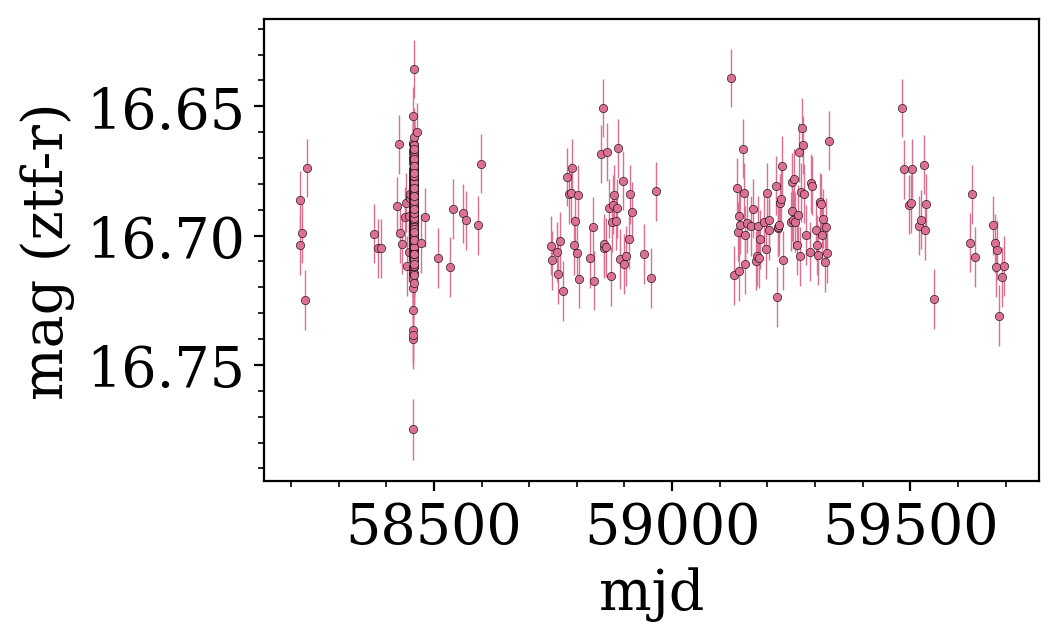

In [41]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], band_of_study='r', flag_good=0)

plt.figure(figsize=(5, 3))
plt.errorbar(time, mag, magerr, fmt='.', color='palevioletred', mec='k', mew=0.2, lw=0.5)
plt.minorticks_on()
plt.xlabel("mjd")
plt.ylabel('mag (ztf-r)')
plt.ylim(plt.ylim()[::-1])

In [42]:
evaluate(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], lc['ra_ztf_source'], lc['dec_ztf_source'], 
         gaia_lite, None)

{'assymetry_score': 0.021223899521268366, 'left_error': 0.0002016309038392275, 'right_error': 0.00027609454012203353, 'log_sum_error': 7.2115195862455215, 'chi-square': 375.2830217157739}


0         0.012521
1         0.018836
2         1.000000
3         4.858071
4     58456.455380
5     58456.507490
6     58456.443500
7         0.002960
8        22.000000
9         0.021224
10      375.283022
11       47.616272
12       12.041212
13        0.063999
14       16.707754
15    29781.891399
dtype: float64

In [655]:
from tqdm import tqdm
for _id in tqdm(ens.object.head(50).index):
    lc = ens.source.loc[_id].compute()
    print (f'Now computing.... {_id}')
    result = evaluate(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], lc['ra_ztf_source'], lc['dec_ztf_source'], 
         gaia_lite, None)

  0%|          | 0/50 [00:00<?, ?it/s]

Now computing.... 6124190825120268288


  2%|▏         | 1/50 [00:04<03:56,  4.83s/it]

No peaks found!


  4%|▍         | 2/50 [00:06<02:28,  3.09s/it]

Now computing.... 6124191013062836224
No dip is found within the minimum number of detections.
No peaks found!
Now computing.... 6124191246257750016


  6%|▌         | 3/50 [00:12<03:27,  4.41s/it]

Now computing.... 6124191326687723520


  8%|▊         | 4/50 [00:20<04:21,  5.69s/it]

Now computing.... 6124284960145670144


 10%|█         | 5/50 [00:30<05:34,  7.43s/it]

Now computing.... 6124285425998626816


 12%|█▏        | 6/50 [00:39<05:46,  7.87s/it]

No peaks found!
Now computing.... 6124285419317100544


 14%|█▍        | 7/50 [00:45<05:10,  7.23s/it]

Now computing.... 6124285541832720384


 16%|█▌        | 8/50 [00:51<04:50,  6.91s/it]

Now computing.... 6124285644991627264


 18%|█▊        | 9/50 [00:57<04:24,  6.45s/it]

Now computing.... 6124285923505995776


 20%|██        | 10/50 [01:03<04:20,  6.52s/it]

Now computing.... 6124286525535420416


 22%|██▏       | 11/50 [01:11<04:33,  7.01s/it]

Now computing.... 6124286607005581312


 24%|██▍       | 12/50 [01:18<04:22,  6.90s/it]

Now computing.... 6124286802434981888


 26%|██▌       | 13/50 [01:26<04:26,  7.19s/it]

Now computing.... 6124286935755128832


 28%|██▊       | 14/50 [01:34<04:25,  7.37s/it]

Now computing.... 6124287411426951168


 30%|███       | 15/50 [01:40<04:08,  7.10s/it]

Now computing.... 6124290044212543488


 32%|███▏      | 16/50 [01:53<04:56,  8.72s/it]

Now computing.... 6124290617573900288


 36%|███▌      | 18/50 [02:02<03:29,  6.56s/it]

Now computing.... 6124292181415952384
No dip is found within the minimum number of detections.
No peaks found!


 38%|███▊      | 19/50 [02:05<02:49,  5.48s/it]

Now computing.... 6124292340153581568
GP failed!
No peaks found!


 40%|████      | 20/50 [02:09<02:25,  4.86s/it]

Now computing.... 6124292744090222592
No dip is found within the minimum number of detections.
No peaks found!
Now computing.... 6124293136689659904


 42%|████▏     | 21/50 [02:16<02:44,  5.66s/it]

Now computing.... 6124293852284059648


 46%|████▌     | 23/50 [02:26<02:17,  5.10s/it]

Now computing.... 6124295724847857664
GP failed!
No peaks found!


 48%|████▊     | 24/50 [02:29<01:55,  4.43s/it]

Now computing.... 6124707728905469952
No dip is found within the minimum number of detections.
No peaks found!


 50%|█████     | 25/50 [02:32<01:40,  4.02s/it]

Now computing.... 6124708078114832384
GP failed!
No peaks found!


 52%|█████▏    | 26/50 [02:35<01:30,  3.76s/it]

Now computing.... 6124708528549527552
No dip is found within the minimum number of detections.
No peaks found!


 54%|█████▍    | 27/50 [02:38<01:25,  3.74s/it]

Now computing.... 6124709507495886848
No dip is found within the minimum number of detections.
No peaks found!


 56%|█████▌    | 28/50 [02:41<01:17,  3.52s/it]

Now computing.... 6124709476399316992
No dip is found within the minimum number of detections.
No peaks found!


 58%|█████▊    | 29/50 [02:44<01:10,  3.36s/it]

Now computing.... 6124709701872517120
No dip is found within the minimum number of detections.
No peaks found!


 60%|██████    | 30/50 [02:47<01:03,  3.20s/it]

Now computing.... 6124709843795181568
GP failed!
No peaks found!


 62%|██████▏   | 31/50 [02:50<00:58,  3.08s/it]

Now computing.... 6124712401217519616
No dip is found within the minimum number of detections.
No peaks found!


 64%|██████▍   | 32/50 [02:53<00:55,  3.07s/it]

Now computing.... 6124715116119195648
GP failed!
No peaks found!


 66%|██████▌   | 33/50 [02:56<00:51,  3.04s/it]

Now computing.... 6124716157652959232
No dip is found within the minimum number of detections.
No peaks found!


 68%|██████▊   | 34/50 [02:59<00:48,  3.02s/it]

Now computing.... 6124716768846938112
No dip is found within the minimum number of detections.
No peaks found!


 70%|███████   | 35/50 [03:02<00:43,  2.92s/it]

Now computing.... 6124717096719876096
GP failed!
No peaks found!


 72%|███████▏  | 36/50 [03:05<00:40,  2.91s/it]

Now computing.... 6124718374648807424
No dip is found within the minimum number of detections.
No peaks found!


 74%|███████▍  | 37/50 [03:08<00:38,  2.98s/it]

Now computing.... 6124718685740335104
GP failed!
No peaks found!


 76%|███████▌  | 38/50 [03:10<00:34,  2.89s/it]

Now computing.... 6124719155087147008
No dip is found within the minimum number of detections.
No peaks found!


 78%|███████▊  | 39/50 [03:13<00:31,  2.83s/it]

Now computing.... 6124719372763136000
No dip is found within the minimum number of detections.
No peaks found!


 80%|████████  | 40/50 [03:17<00:30,  3.10s/it]

Now computing.... 6124719522814361600
No dip is found within the minimum number of detections.
No peaks found!


 82%|████████▏ | 41/50 [03:20<00:27,  3.11s/it]

Now computing.... 6124738501628919808
No dip is found within the minimum number of detections.
No peaks found!


 84%|████████▍ | 42/50 [03:23<00:25,  3.13s/it]

Now computing.... 6124739361608040448
No dip is found within the minimum number of detections.
No peaks found!


 86%|████████▌ | 43/50 [03:26<00:21,  3.13s/it]

Now computing.... 6124740976058564608
No dip is found within the minimum number of detections.
No peaks found!


 88%|████████▊ | 44/50 [03:29<00:18,  3.03s/it]

Now computing.... 6124742375249018880
No dip is found within the minimum number of detections.
No peaks found!


 90%|█████████ | 45/50 [03:33<00:15,  3.13s/it]

Now computing.... 6124742738660294656
No dip is found within the minimum number of detections.
No peaks found!


 92%|█████████▏| 46/50 [03:35<00:12,  3.09s/it]

Now computing.... 6124743056034889728
No dip is found within the minimum number of detections.
No peaks found!


 94%|█████████▍| 47/50 [03:39<00:09,  3.09s/it]

Now computing.... 6124743478350970880
GP failed!
No peaks found!


 96%|█████████▌| 48/50 [03:41<00:05,  2.99s/it]

Now computing.... 6124743942748504064
No dip is found within the minimum number of detections.
No peaks found!


 98%|█████████▊| 49/50 [03:45<00:03,  3.07s/it]

Now computing.... 6124744188283060224
GP failed!
No peaks found!


100%|██████████| 50/50 [03:47<00:00,  4.56s/it]

Now computing.... 6124745004846940160
GP failed!
No peaks found!


In [66]:
import matplotlib.pyplot 

In [67]:
cm = matplotlib.pyplot.get_cmap('RdBu')

In [104]:
xx = np.linspace(-10, 10, 100) + np.random.normal(0, 1, 100)
yy = dip_models.skew_norm(xx, 0, 2, 0, 16, 0.1) + np.random.normal(0, 0.001, 100)

In [148]:
scr = []
from tqdm import tqdm
for j in tqdm(np.linspace(-5, 5, 30)):
    xx = np.linspace(-10, 10, 100) + np.random.normal(0, 1, 100)
    yy = dip_models.skew_norm(xx, 0, 2, j, 16, 0.1) + np.random.normal(0, 1e-12, 100)

    gp = dip_pipeline.GaussianProcess_dip(xx, yy, abs(np.random.normal(0, 1e-8, len(xx))), alpha=1, metric=100)

    # GP assesment of quality 
    gp_quality = dip_pipeline.evaluate_dip(gp, xx, yy, abs(np.random.normal(0, 1e-8, len(xx))), 
                                           np.median(yy), np.std(yy), 0, diagnostic=False)

    scr.append(gp_quality['assymetry_score'])

100%|██████████| 30/30 [00:12<00:00,  2.47it/s]


In [166]:
sk = np.linspace(-3, 3, 10)
sig = np.linspace(0.1, 5, 10)

xx = np.linspace(-15, 15, 50) + np.random.normal(0, 1, 50)
nz = abs(np.random.normal(0, 1e-8, len(xx)))

X, Y = np.meshgrid(sk, sig, indexing='xy')

Master = np.zeros(shape=np.shape(X))

for i in tqdm(range(len(X))):
    for j in range(len(Y)):
        yy = dip_models.skew_norm(xx, 0, sig[j], sk[i], 16, 0.1) 
        gp = dip_pipeline.GaussianProcess_dip(xx, yy, nz, alpha=1, metric=100)

        # GP assesment of quality 
        gp_quality = dip_pipeline.evaluate_dip(gp, xx, yy, nz, 
                                           np.median(yy), np.std(yy), 0, diagnostic=False)
        
        Master[i,j] = gp_quality['assymetry_score']
        
        

100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


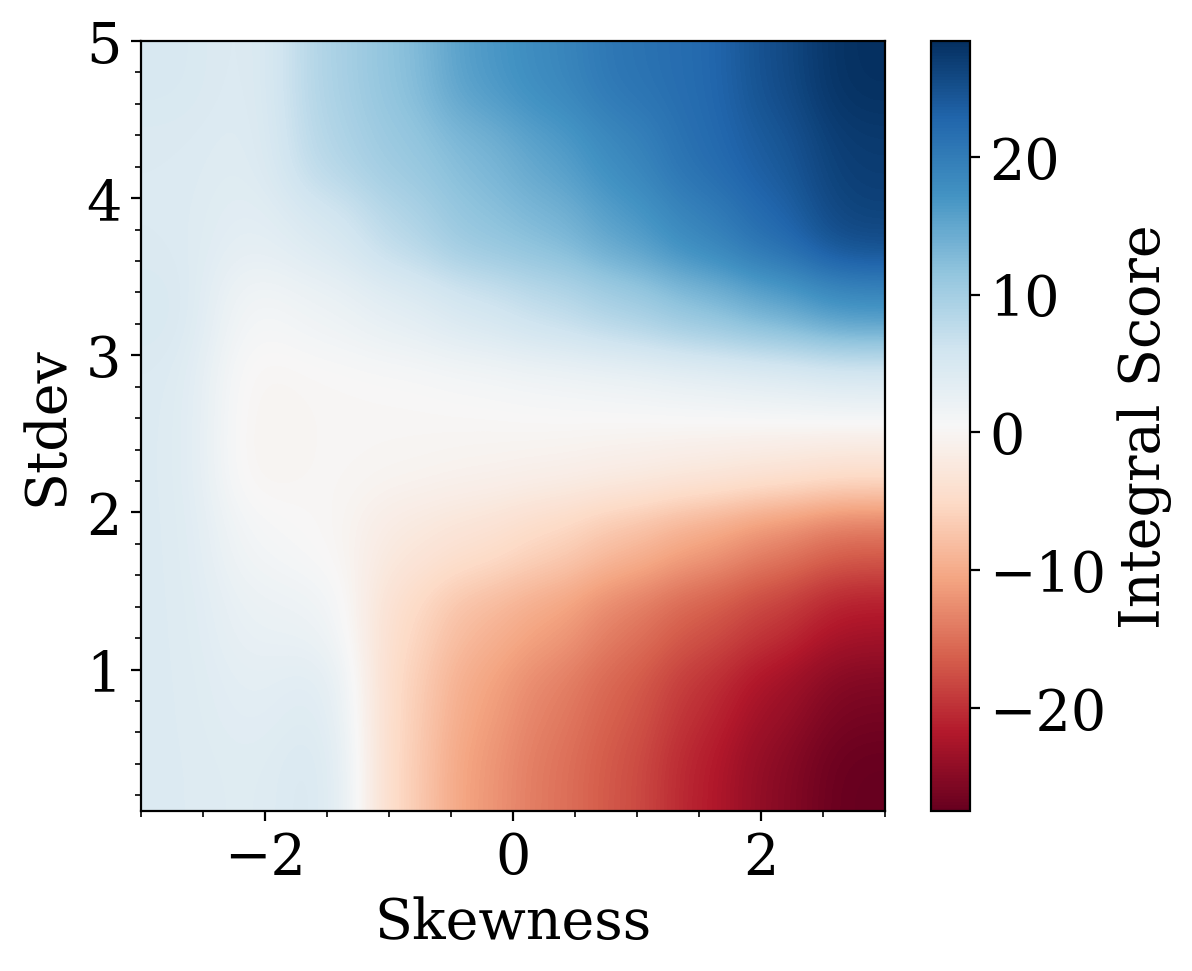

In [200]:
plt.figure(figsize=(6,5))
plt.imshow((Master), cmap='RdBu', extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], aspect='auto', 
          interpolation='Gaussian')
plt.colorbar(label='Integral Score')
plt.xlabel("Skewness")
plt.ylabel("Stdev")
plt.minorticks_on()

Text(-0.9, 16.01, 'Skew<0')

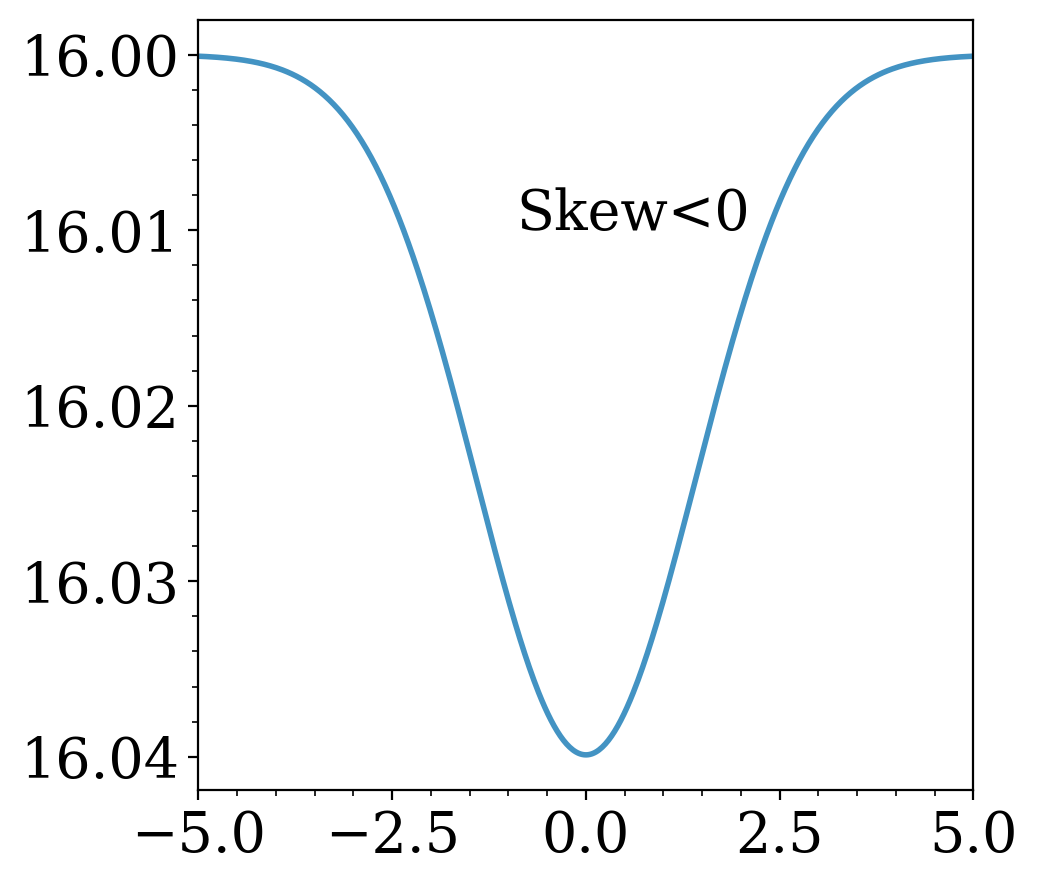

In [86]:
xx = np.linspace(-10, 10, 1000)
yy = dip_models.skew_norm(xx, 0, 2, 0, 16, 0.1)

plt.figure(figsize=(5,5))
plt.plot(xx, yy, color=cm(0.8), lw=2)
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.xlim(-5, 5)
plt.text(-0.9, 16.01, "Skew<0")

Text(0.5, 0, 'Phase')

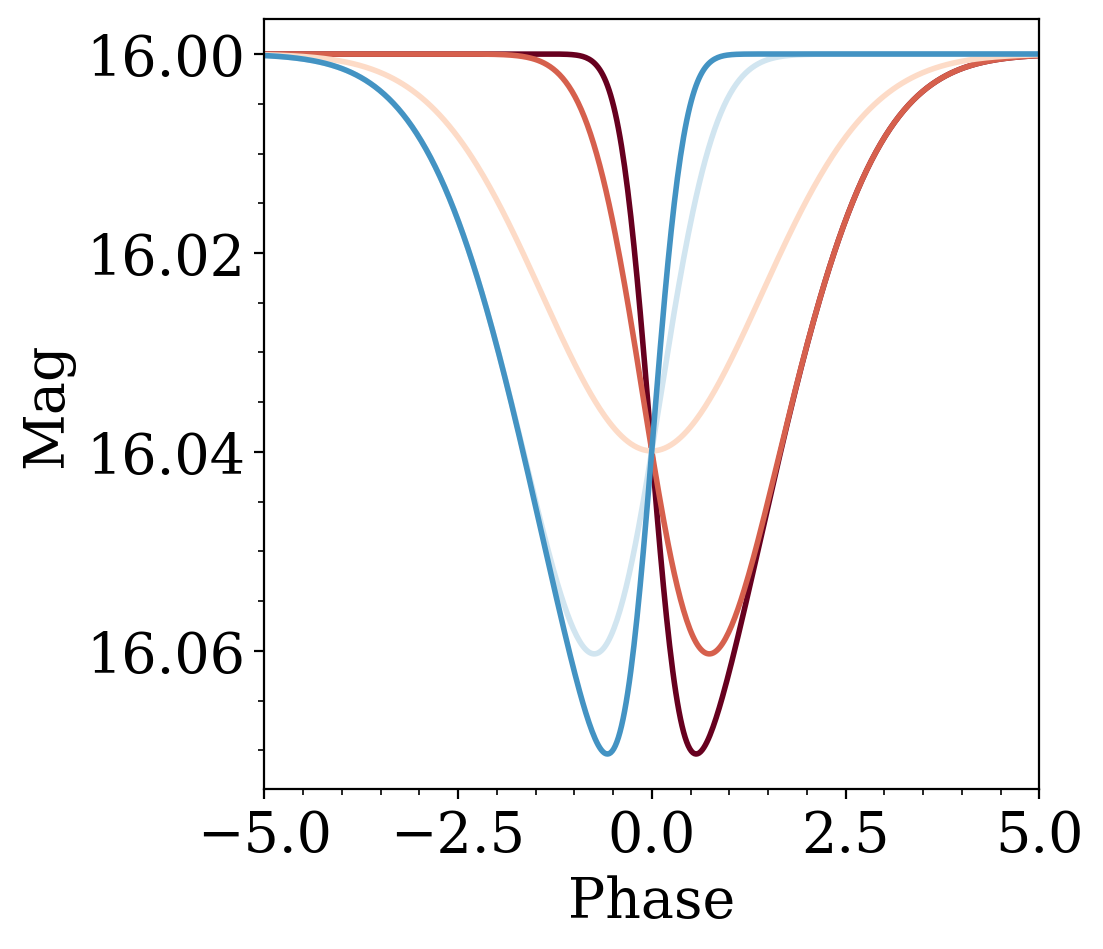

In [960]:
# fun plot 
xx = np.linspace(-10, 10, 1000)
ce = 0
plt.figure(figsize=(5,5))
for i in np.linspace(-3, 3, 5)[::-1]:
    yy = dip_models.skew_norm(xx, 0, 2, i, 16, 0.1)
    plt.plot(xx, yy, color=cm(ce), lw=2)
    ce += 0.2
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.xlim(-5, 5)
plt.ylabel("Mag")
plt.xlabel("Phase")

## Synthetic Observations

In [850]:
model = dip_models.skew_norm(time, np.median(time)+320, 15, -3, 16, 1) + np.random.normal(0, 0.001, len(time))
model_err = magerr

In [43]:
scr = []
for i in np.arange(-3, 3, step=0.25):
    model = dip_models.skew_norm(time, 
                                 np.median(time)+340,
                                 25, i, 16, 0.15) #
    model_err = 0.2*magerr

    tb = pd.DataFrame([],columns=('mjd', 'mag', 'magerr', 'flag', 'band'))

    tb['mjd'] = time
    tb['mag'] = model
    tb['magerr'] = model_err
    tb['flag'] = np.zeros(len(time))
    tb['band'] = ['r' for _ in range(len(time))]

    final = evaluate(tb['mjd'], tb['mag'], tb['magerr'], tb['flag'], tb['band'], 
            np.array([121, 123]), np.array([31, 31.3]), gaia_lite, None)
    scr.append(final.iloc[9])

{'assymetry_score': 395.7795107266872, 'left_error': 0.00310263094532, 'right_error': 3.403115186134597e-05, 'log_sum_error': 8.570701347318654, 'chi-square': 0.14145266244788846}
{'assymetry_score': 396.41217107264123, 'left_error': 0.0030961067331942865, 'right_error': 3.3342907686605207e-05, 'log_sum_error': 8.57516523621365, 'chi-square': 0.14273033028965024}
{'assymetry_score': 397.44739470655435, 'left_error': 0.003085413063639003, 'right_error': 3.2221921097405836e-05, 'log_sum_error': 8.582596406778807, 'chi-square': 0.14489467798425834}
{'assymetry_score': 399.04444252223544, 'left_error': 0.003068836627361609, 'right_error': 3.0499314568428076e-05, 'log_sum_error': 8.594433255042619, 'chi-square': 0.14844028107784654}
{'assymetry_score': 401.35161589820297, 'left_error': 0.0030446331743205443, 'right_error': 2.8015448754791575e-05, 'log_sum_error': 8.61250279701714, 'chi-square': 0.15409372610006128}
{'assymetry_score': 404.4380390497225, 'left_error': 0.0030114880357163024, 

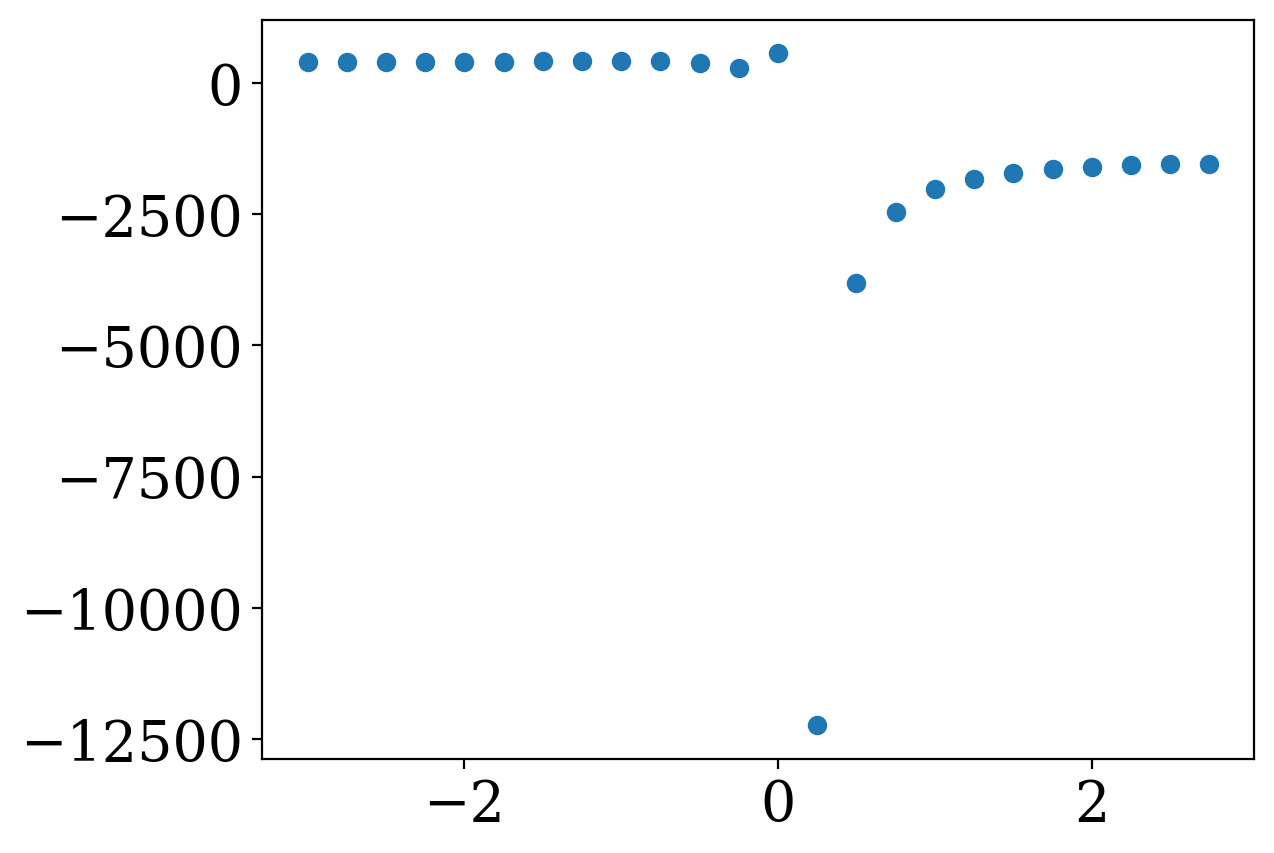

In [46]:
plt.scatter(np.arange(-3, 3, step=0.25), np.array(scr))

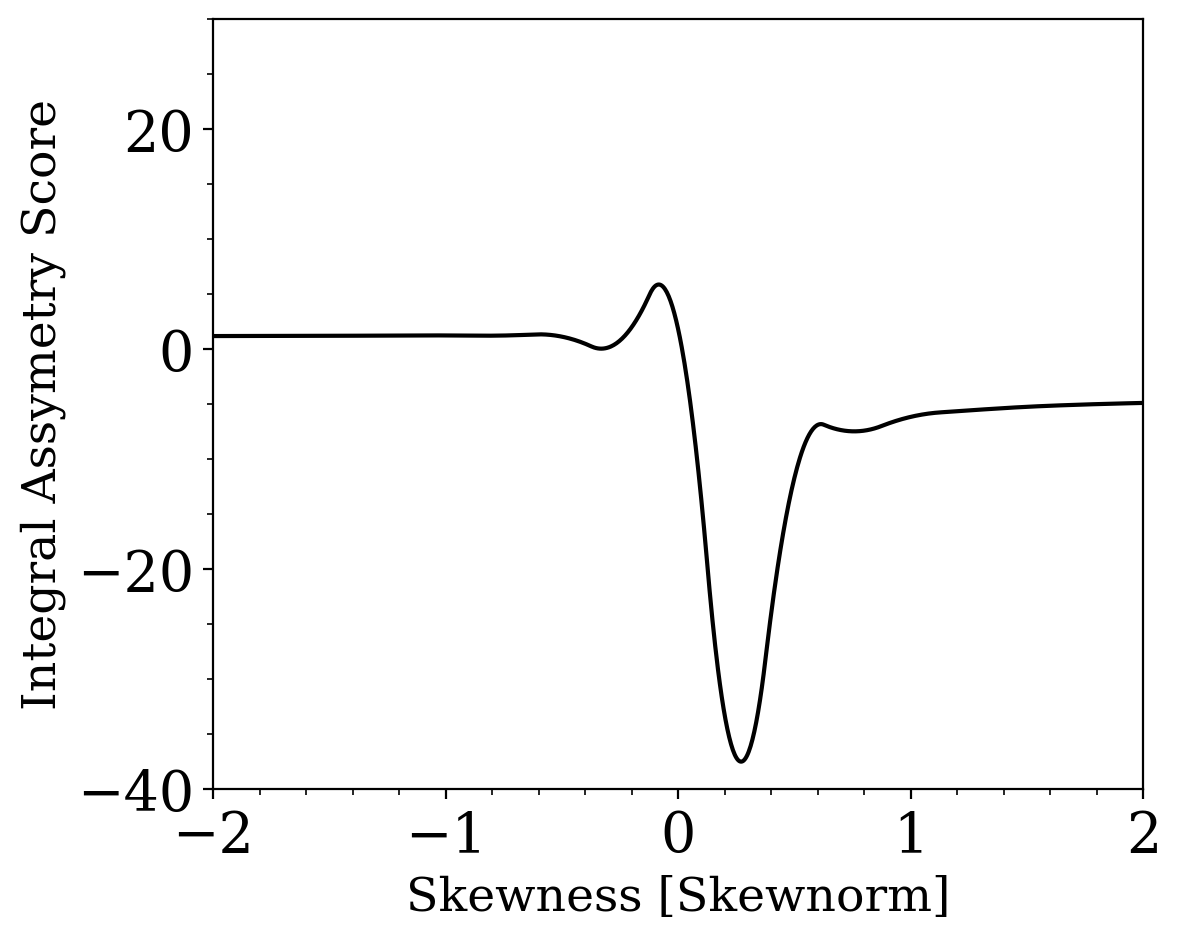

In [64]:
from scipy.interpolate import interp1d

plt.figure(figsize=(6,5))
f = interp1d(np.arange(-3, 3, step=0.25), (np.array(scr))/np.median(scr), kind='quadratic')
x1 = np.linspace(-2, 2, 1000)

plt.plot(x1, f(x1), color='k')
plt.xlim(-2, 2)
plt.ylim(-40, 30)

plt.ylabel("Integral Assymetry Score", fontsize=17)
plt.xlabel("Skewness [Skewnorm]", fontsize=17)
plt.minorticks_on()

Text(0.5, 1.0, 'Mock example')

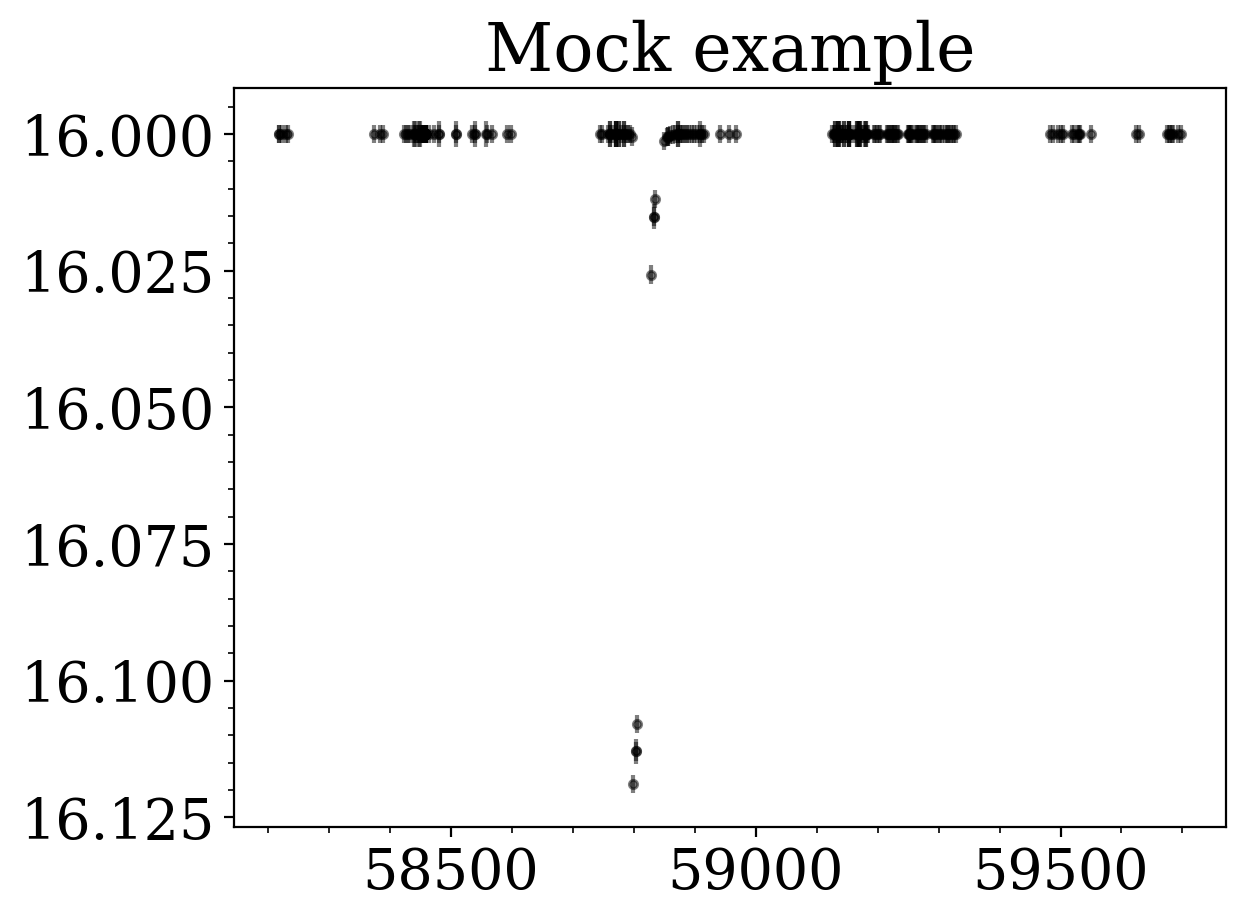

In [1009]:
plt.errorbar(time, model, yerr=model_err, fmt='.', 
            color='k', alpha=0.5)
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.title("Mock example")
#plt.xlim(np.median(time)+300-50, np.median(time)+300+50)

Text(0.5, 1.0, 'Mock example')

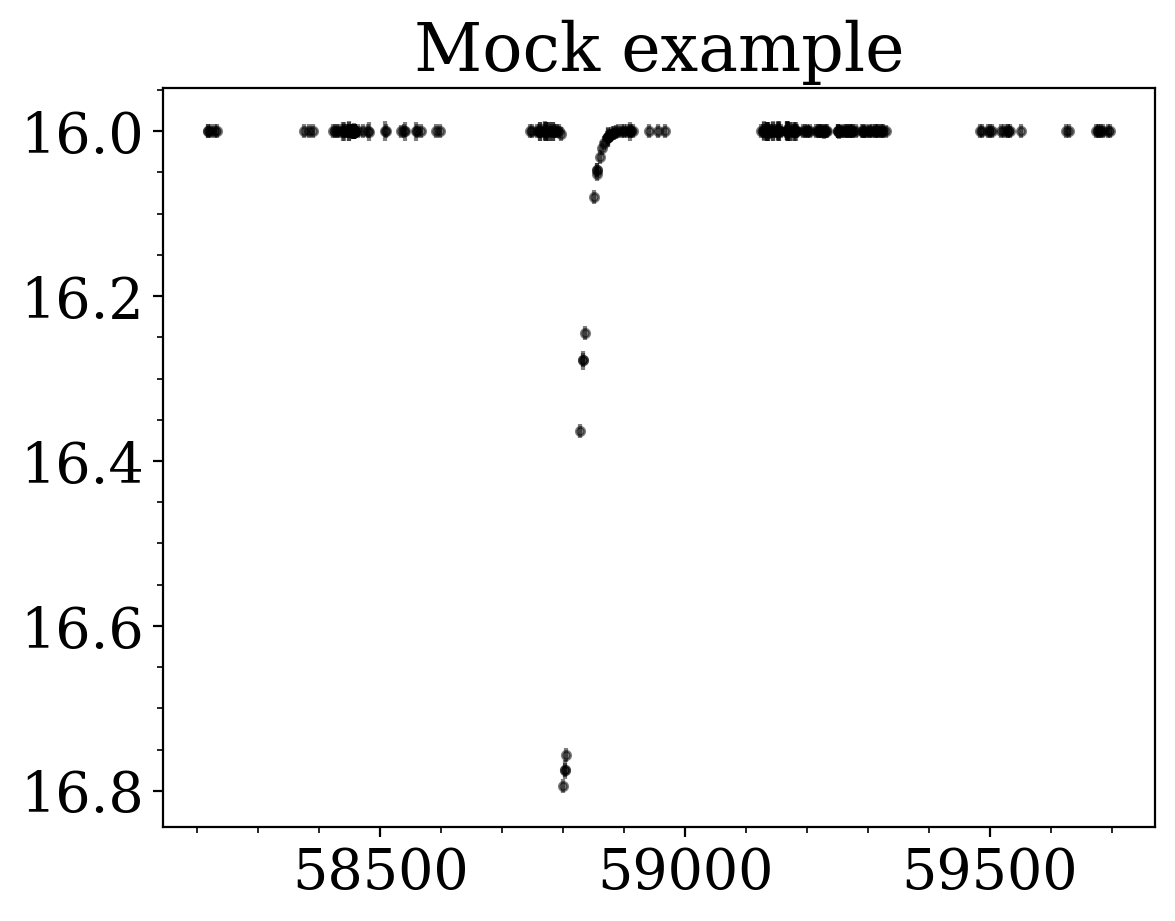

In [852]:
tb = pd.DataFrame([],columns=('mjd', 'mag', 'magerr', 'flag', 'band'))

In [853]:
tb['mjd'] = time
tb['mag'] = model
tb['magerr'] = model_err
tb['flag'] = np.zeros(len(time))
tb['band'] = ['r' for _ in range(len(time))]

In [854]:
evaluate(tb['mjd'], tb['mag'], tb['magerr'], tb['flag'], tb['band'], 
        np.array([121, 123]), np.array([31, 31.3]), gaia_lite, None)

{'assymetry_score': 163.72060606237912, 'left_error': 0.02711417888322459, 'right_error': 0.0013130027421399168, 'log_sum_error': 6.744194649155939, 'chi-square': 0.1535617365139034}


0         0.001037
1         0.019078
2         1.000000
3        68.490363
4     58776.476930
5     58783.498000
6     58598.145100
7         2.357344
8        15.000000
9       163.720606
10        0.153562
11       45.206441
12       18.010384
13       29.397590
14       18.249557
15     3436.372084
dtype: float64

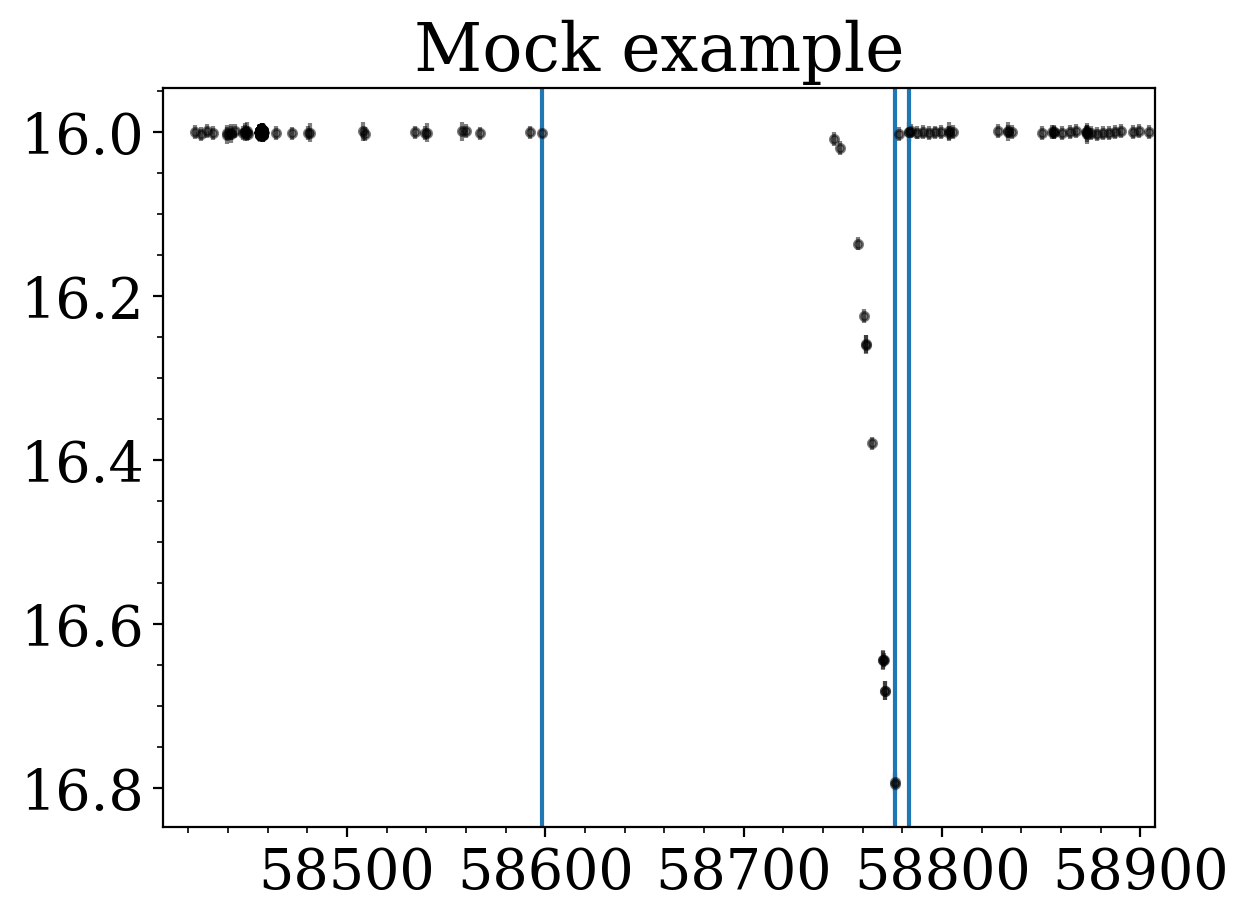

In [856]:
plt.errorbar(time, model, yerr=model_err, fmt='.', 
            color='k', alpha=0.5)
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.title("Mock example")
plt.xlim(np.median(time)+300-350, np.median(time)+300+150)
plt.axvline(58776.476930)
plt.axvline(58783.498000)
plt.axvline(58598.145100)